# Assignment:
- Using the approved dataset you proposed for project 2 part 1 last week, you will clean and explore the data set.

- To meet the requirements for this week you must have:

- [X] Deleted unnecessary columns.
- [X] Deleted duplicate rows.
- [X] Identified and addressed missing values.
- [X] Identified and corrected inconsistencies in data for categorical values (i.e. Cat, cat, cats).
- [ ] Produced univariate visuals for the target and all features.
- [X] Identified outliers.
- [ ] Clearly commented all of your cleaning steps and described any decisions you made.

### Importing modules

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
# This function will print all available information about the dataframe
def print_df_info(df):
    print("Rows and Column:")
    print(df.shape, '\n')
    print('Getting the described function information:')
    print(df.describe(), '\n')
    print('Getting the info() function information:')
    print(df.info())

print_df_info(df)

Rows and Column:
(918, 12) 

Getting the described function information:
              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1

- First, let seeing what the rows correlations to are target columns `HeartDisease'.

<AxesSubplot:>

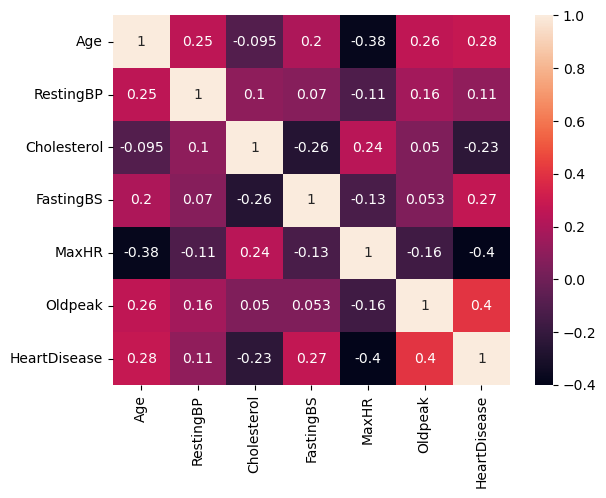

In [5]:
# Using .corr() to create a correlation matrix
corr = df.corr()
# Using seaborn library to create a heat map of df to see the correlations between target and features
sns.heatmap(corr, annot=True)

In the graph above, the columns that has the worst correlation with our target variable would be column `'Cholesterol'`. Even though `MaxHR` has a negative correlation with `HeartDisease`, it has a strong negative correlation with `HeartDieases`, just like how `Oldpeak` has a strong correlation with `HeartDisease`.

- Now I will drop Cholesterol since the column have the worst correlation to the target variable.

In [6]:
# Saving copy of dataframe incase of data leakage
df_copy = df.copy()

# Dropping unnecessary columns
df_copy.drop(columns="Cholesterol", inplace=True)

In [7]:
# viewing dataframe to see if changes were made
df_copy.head()

,Age,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,0,Normal,122,N,0.0,Up,0


Now, I will check for duplicated rows in the dataset.

In [8]:
# Checking for duplicate rows
df_copy.duplicated().sum()

0

Next, I will check for any missing values in this dataset.

In [9]:
# Checking for null values in rows and columns
df_copy.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

- To make sure that the data does not contain any outliers or inconsistencies. I will run the following code:

In [10]:
# Printing the max of every column in df
print(f'Max\nThis is the max value: {df_copy.max()}\n')
# Creating the min of every column in df
print(f'Min\nThis is the min value: {df_copy.min()}')

Max
This is the max value: Age                77
Sex                 M
ChestPainType      TA
RestingBP         200
FastingBS           1
RestingECG         ST
MaxHR             202
ExerciseAngina      Y
Oldpeak           6.2
ST_Slope           Up
HeartDisease        1
dtype: object

Min
This is the min value: Age                 28
Sex                  F
ChestPainType      ASY
RestingBP            0
FastingBS            0
RestingECG         LVH
MaxHR               60
ExerciseAngina       N
Oldpeak           -2.6
ST_Slope          Down
HeartDisease         0
dtype: object


Printing the max and min values of df will tell me if we have any rows that are extreme outliers. I concluded that there aren't any rows with extreme outliers.

In [11]:
for i in df_copy.columns:
    print(i)
    print(df[i].value_counts())

Age
54    51
58    42
55    41
56    38
57    38
52    36
51    35
59    35
62    35
53    33
60    32
48    31
61    31
63    30
50    25
46    24
41    24
43    24
64    22
65    21
49    21
47    19
44    19
42    18
45    18
38    16
67    15
39    15
66    13
69    13
40    13
35    11
37    11
68    10
34     7
74     7
70     7
36     6
71     5
32     5
72     4
29     3
75     3
33     2
77     2
76     2
31     2
30     1
28     1
73     1
Name: Age, dtype: int64
Sex
M    725
F    193
Name: Sex, dtype: int64
ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64
RestingBP
120    132
130    118
140    107
110     58
150     55
      ... 
185      1
98       1
92       1
113      1
164      1
Name: RestingBP, Length: 67, dtype: int64
FastingBS
0    704
1    214
Name: FastingBS, dtype: int64
RestingECG
Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64
MaxHR
150    43
140    41
120    36
130    33
160    25
       ..
63 

- It appears that there are no inconsistencies in the catergorical or numerical data.

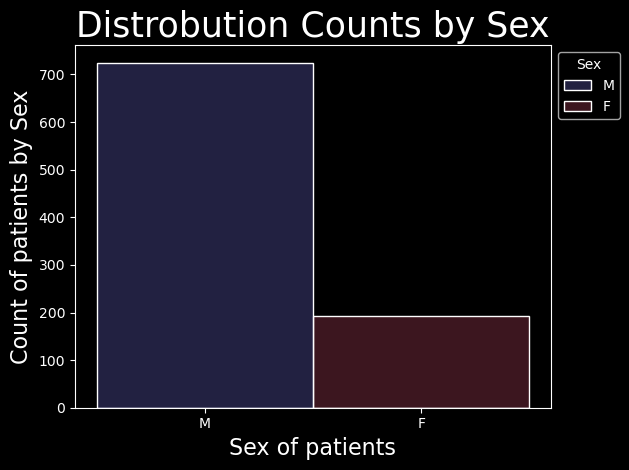

In [33]:
# Using with plt.style.context to format only this histsgram
with plt.style.context(['seaborn-muted', 'dark_background']):
    # Plotting histogram with seaborns histplot
    ax = sns.histplot(data=df_copy, x=df['Sex'], hue=df['Sex'], legend=True, palette='icefire', zorder=3)
    # setting xlabel for histogram
    plt.xlabel('Sex of patients', fontsize=16)
    # setting ylabel for histogram
    plt.ylabel('Count of patients by Sex', fontsize=16)
    # Creating title for histogram
    plt.title('Distrobution Counts by Sex', fontsize=25)
    # Creating legend for histogram
    sns.move_legend(bbox_to_anchor=(1, 1), loc=2, obj=ax)
    plt.tight_layout()

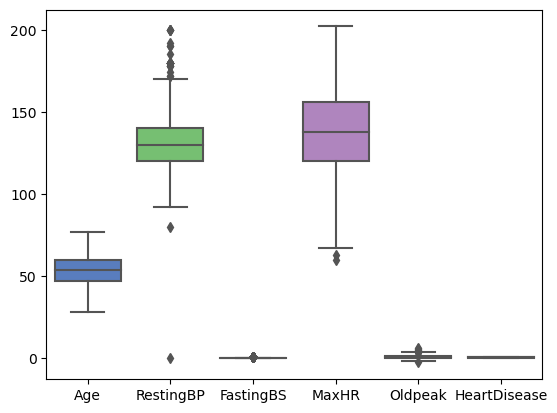

In [13]:
with plt.style.context(['seaborn-muted']):
    sns.boxplot(data=df_copy)